## **Configuracion Inicial**

In [ ]:
rm(list=ls())

require(pacman)

p_load("dplyr",
       "tidyverse",
       "rugarch",
       "readxl",
       "xts",
       "ggplot2",
       "stargazer")

if (tail(strsplit(getwd(), "/")[[1]], n = 1) == "scripts") {
  setwd("..")
}

getwd()


## **Cargue y preparacion de datos**

In [ ]:
trm  <- read_excel("data\\TRM.xlsx")

trm  <- trm %>% rename(
                        fecha = `Fecha (dd/mm/aaaa)`,
                        trm = `Tasa de cambio representativa del mercado (TRM)`
                        )

trm$fecha <- as.Date(trm$fecha)

trm  <- trm[order(trm$fecha),]

trm <- trm %>%
  mutate(fecha = format(fecha, "%Y-%m")) %>%
  group_by(fecha) %>%
  summarise(trm = mean(trm, na.rm = TRUE))  %>% 
  ungroup()

trm  <- trm %>% mutate(
                        retorno = 100*(log(trm)-log(lag(trm,1)))
                        )

trm  <- na.omit(trm)

mean(trm$retorno, na.omit = TRUE)


## **2.f. Dinámicas de varianza (parte 2)**

In [ ]:
model_spec  <- ugarchspec(
                          variance.model = list(model = "sGARCH", garchOrder = c(1, 1)), # nolint: line_length_linter.
                          mean.model = list(armaOrder = c(0, 1), include.mean = TRUE),  # nolint: line_length_linter.
                          distribution.model = "norm"
                        )

model  <- ugarchfit(spec = model_spec, data = trm$retorno)

show(model)

resid <-  residuals(model)

var  <- sigma(model)

resid_std  <-  resid / sqrt(var)

resid_std2  <- resid_std^2

trm$resid_std  <- coredata(resid_std)

trm$resid_std2  <- coredata(resid_std2)

head(trm)


## **2.g. Verificar que el modelo captura las dinamicas**

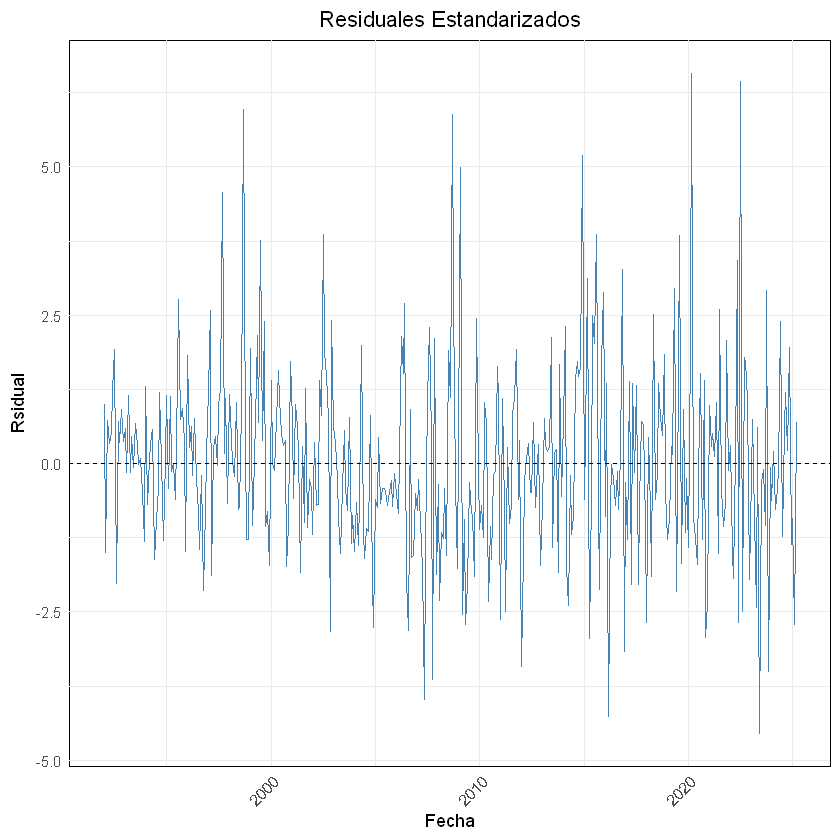

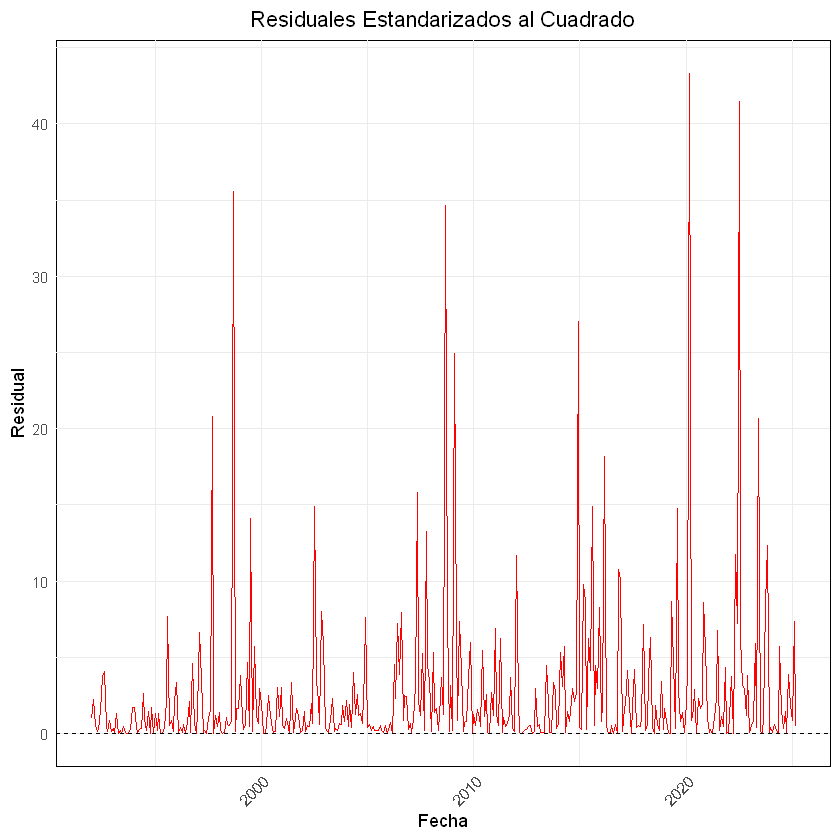

In [145]:
trm$fecha <- as.Date(paste0(trm$fecha, "-01"))

plot  <-  ggplot(trm, aes(x = fecha, y = resid_std,group=1)) +
  geom_line(color = "steelblue") +
  labs(title = "Residuales Estandarizados", x = "Fecha", y = "Rsidual") +
  geom_hline(yintercept = 0, linetype = "dashed", color = "#000000") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    plot.title = element_text(hjust = 0.5),
    panel.background = element_rect(fill = "#ffffff"),
    plot.background = element_rect(fill = "#ffffff", color = NA)
  )
plot

ggsave("output\\graf_resistd.png", plot = plot, width = 8, height = 6, dpi = 300)

plot  <-  ggplot(trm, aes(x = fecha, y = resid_std2,group=1)) +
  geom_line(color = "#ff0000") +
  labs(title = "Residuales Estandarizados al Cuadrado", x = "Fecha", y = "Residual") +
  geom_hline(yintercept = 0, linetype = "dashed", color = "#000000") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    plot.title = element_text(hjust = 0.5),
    panel.background = element_rect(fill = "#ffffff"),
    plot.background = element_rect(fill = "#ffffff", color = NA)
  )

plot

ggsave("output\\graf_resistd2.png", plot = plot, width = 8, height = 6, dpi = 300)

In [ ]:
lags <- c(5, 10, 15)

results <- lapply(lags, function(lag_val) {
  test <- Box.test(trm$resid_std2, lag = lag_val, type = "Ljung-Box")
  data.frame(
    Rezago = lag_val,
    `Estad\\'istico` = test$statistic,
    p_valor = test$p.value
  )
})


df_q_test <- do.call(rbind, results)

rownames(df_q_test) <- NULL

df_q_test

latex_txt  <- stargazer(as.matrix(df_q_test), summary = FALSE, rownames = FALSE, type = "latex", label = "tab:q_residstd2",title = "Prueba Q para Residuales Estandarizados al Cuadrado")


latex_txt <- gsub(
  pattern = "^\\\\begin\\{table\\}\\[!htbp\\] \\\\centering",
  replacement = "\\\\begin{table}[H] \\\\centering",
  x = latex_txt
)

# Check the result
cat(latex_txt, sep = "\n")

writeLines(latex_txt, "output\\q_resid2.tex")


Rezago,Estad..istico,p_valor
<dbl>,<dbl>,<dbl>
5,3.768133,0.5832582
10,8.231610,0.6062250
15,13.362952,0.5742857



% Table created by stargazer v.5.2.3 by Marek Hlavac, Social Policy Institute. E-mail: marek.hlavac at gmail.com
% Date and time: dom, abr 06, 2025 - 18:25:46
\begin{table}[!htbp] \centering 
  \caption{Prueba Q para Residuales Estandarizados al Cuadrado} 
  \label{tab:q_residstd2} 
\begin{tabular}{@{\extracolsep{5pt}} ccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
Rezago & Estad..istico & p\_valor \\ 
\hline \\[-1.8ex] 
$5$ & $3.768$ & $0.583$ \\ 
$10$ & $8.232$ & $0.606$ \\ 
$15$ & $13.363$ & $0.574$ \\ 
\hline \\[-1.8ex] 
\end{tabular} 
\end{table} 

% Table created by stargazer v.5.2.3 by Marek Hlavac, Social Policy Institute. E-mail: marek.hlavac at gmail.com
% Date and time: dom, abr 06, 2025 - 18:25:46
\begin{table}[H] \centering 
  \caption{Prueba Q para Residuales Estandarizados al Cuadrado} 
  \label{tab:q_residstd2} 
\begin{tabular}{@{\extracolsep{5pt}} ccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
Rezago & Estad..istico & p\_valor \\ 
\hline \\[-1.8ex] 
$5$ & $3.768$ & $0.583$ \\